In [1]:
import numpy as np
import pandas as pd
import sklearn
import sklearn.model_selection

from recommend.utils import PROJ_ROOT
from recommend.cf_recommenders import CFBaseline, CFGradFactor

In [2]:
ratings = pd.read_pickle(f"{PROJ_ROOT}/data/ratings.pkl")

In [3]:
ratings.shape

(2797751, 5)

In [4]:
def filter_ratings(ratings: pd.DataFrame, min_user_ratings: int, min_movie_ratings: int) -> pd.DataFrame:
    ratings = ratings.dropna()

    user_rating_count = ratings.groupby("username").size()
    worthy_users = set(user_rating_count[user_rating_count >= min_user_ratings].index)
    ratings = ratings.loc[ratings.username.isin(worthy_users)]

    movie_rating_count = ratings.groupby("movie_id").size()
    worthy_movies = set(movie_rating_count[movie_rating_count >= min_movie_ratings].index)
    ratings = ratings.loc[ratings.movie_id.isin(worthy_movies)]
    
    return ratings

In [5]:
ratings = filter_ratings(ratings, 10, 10)

In [6]:
ratings.shape

(2722362, 5)

In [7]:
ratings_train, ratings_test = sklearn.model_selection.train_test_split(
    ratings,
    test_size=0.1,
    shuffle=True,
    random_state=0,
)

ratings_train, ratings_valid = sklearn.model_selection.train_test_split(
    ratings_train,
    test_size=0.1,
    shuffle=True,
    random_state=0,
)

In [8]:
ratings_train.head()

,username,movie_id,stars,date,comment
328863,pepo,2596-osm-a-pul,1.0,2018-04-24,"Súhlasím, že 8 1/2 je umelecký film. Je totiž..."
1601217,Melly.pro,224137-hvezdny-prach,5.0,2008-01-18,"Tak nejsem si úplně jistej, co o tom říct, pr..."
1369474,GOREGASM,223564-kazatel,2.0,2016-01-31,Béčkové vody zakalené do digitálního apokalyp...
499592,Ernie_13,308635-zpatky-ve-hre,3.0,2014-03-07,"No je to tých 70%....hrozná réžia, hrozný sce..."
2322162,Khumbac,71194-walker-texas-ranger,4.0,2012-07-14,"Z nostalgie, z recese, z úcty ke komedii dává..."


In [9]:
baseline = CFBaseline()
baseline.train(ratings_train)

In [10]:
recommenders = {}
num_features_list = [2, 5, 10, 20, 30]

In [11]:
import math

for num_features in num_features_list:

    print()
    print("=" * 100)
    print(num_features)
    print()

    recommender = CFGradFactor(
        all_movies=ratings.movie_id.unique().tolist(),
        all_users=ratings.username.unique().tolist(),
        num_features=num_features,
        init_scale=0.05,
        init_shift=math.sqrt(0.5/num_features),
    )

    recommender.train(
        ratings_train,
        ratings_valid,
        learning_rate=0.001,
        batch_size=256,
        early_stopping_threshold=0.02,
        max_epochs=4,
        evaluate_every_n_steps=4000,
        return_to_best=True,
        path_to_save=f"{PROJ_ROOT}/models/cf_recommender_{num_features:02}.pt",
    )

    recommenders[num_features] = recommender



2


5


10


20


30



In [12]:
import matplotlib.pyplot as plt

for num_features, recommender in recommenders.items():
    try:
        pd.DataFrame({
            "Train MAE stars": pd.DataFrame(recommender.trainer.metrics_train).mae_stars,
            "Valid MAE stars": pd.DataFrame(recommender.trainer.metrics_valid).mae_stars,
        }).plot(title=f"Learning curve ({num_features} features)")
        plt.show()
    except:
        pass

<AxesSubplot:>

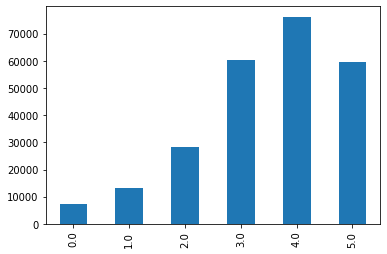

In [13]:
ratings_valid.stars.round().value_counts().sort_index().plot.bar()

<AxesSubplot:>

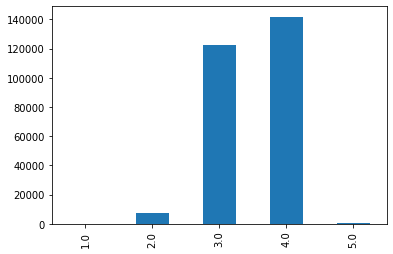

In [14]:
pd.Series(baseline.predict_ratings(ratings_test.movie_id, ratings_test.username)).round().value_counts().sort_index().plot.bar()

<AxesSubplot:>

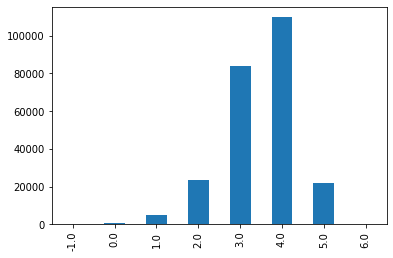

In [15]:
pd.Series(recommenders[10].predict_ratings(ratings_valid.movie_id, ratings_valid.username)).round().value_counts().sort_index().plot.bar()

In [16]:
df_movies = pd.read_pickle(f"{PROJ_ROOT}/data/movies.pkl")
df_movies.head()

,title,description,kind,genres,countries,year,length,poster,foreign_titles,creators
movie_id,,,,,,,,,,
230421-houbicky,Houbičky,"Partička amerických teenagerů, která si vyrazi...",movie,"[Horor, Thriller]","[Irsko, Velká Británie, Dánsko]",2007,84 min,//image.pmgstatic.com/cache/resized/w420/files...,{'Irsko': 'Shrooms'},"{'Režie': [('/tvurce/4690-paddy-breathnach/', ..."
10789-prvni-liga,První liga,V nejvyšší lize získávají hráči baseballu boha...,movie,"[Komedie, Sportovní]",[USA],1989,107 min,//image.pmgstatic.com/cache/resized/w420/files...,"{'USA': 'Major League', 'Slovensko': 'Prvá liga'}","{'Režie': [('/tvurce/4010-david-s-ward/', 'Dav..."
235032-yes-man,Yes Man,"Carl Allen je zatrpklý bankovní úředník, který...",movie,"[Komedie, Romantický]",[USA],2008,100 min,//image.pmgstatic.com/files/images/film/poster...,"{'Austrálie': 'Yes Man', 'Kanada': 'Yes Man', ...","{'Režie': [('/tvurce/8883-peyton-reed/', 'Peyt..."
234754-chlapec-v-pruhovanem-pyzamu,Chlapec v pruhovaném pyžamu,Osmiletý Bruno žije se svojí rodinou v Berlíně...,movie,"[Drama, Válečný]","[Velká Británie, USA]",2008,94 min,//image.pmgstatic.com/files/images/film/poster...,"{'USA': 'The Boy in the Striped Pajamas', 'ang...","{'Režie': [('/tvurce/6600-mark-herman/', 'Mark..."
301717-nejvetsi-showman,Největší showman,Hugh Jackman vévodí hvězdnému obsazení odvážné...,movie,"[Muzikál, Životopisný, Drama]",[USA],2017,105 min,//image.pmgstatic.com/cache/resized/w420/files...,"{'USA': 'The Greatest Showman', 'Slovensko': '...","{'Režie': [('/tvurce/78497-michael-gracey/', '..."


In [17]:
from sklearn.metrics import mean_absolute_error as mae

In [18]:
glob_avg = ratings_train.stars.mean()

evaluation = pd.DataFrame()

for part, name in  [(ratings_train, "train"), (ratings_valid, "valid"), (ratings_test, "test")]:

    baseline_preds = baseline.predict_ratings(part.movie_id, part.username)
    
    results = {
        f"global avg {glob_avg:<0.2f}": mae(part.stars, np.ones_like(part.stars) * glob_avg),
        "baseline": mae(part.stars, baseline_preds),
        "baseline + round": mae(part.stars, baseline_preds.round()),
    }

    for num_features, recommender in recommenders.items():
        if num_features in {2, 5, 10, 30}:
            model_preds = np.clip(recommender.predict_ratings(part.movie_id, part.username), 0, 5)
            results[f"model {num_features}"] = mae(part.stars, model_preds)
            results[f"model {num_features} + round"] = mae(part.stars, model_preds.round())

    evaluation[name] = pd.Series(results)


In [19]:
evaluation

,train,valid,test
global avg 3.48,1.059991,1.058233,1.058616
baseline,0.846989,0.851608,0.853504
baseline + round,0.802943,0.807443,0.810162
model 2,0.762679,0.772321,0.775753
model 2 + round,0.727014,0.736569,0.740641
model 5,0.762892,0.772538,0.775972
model 5 + round,0.727352,0.736969,0.740843
model 10,0.763193,0.772712,0.776201
model 10 + round,0.727651,0.737100,0.741233
model 30,0.764402,0.773948,0.777535


<AxesSubplot:>

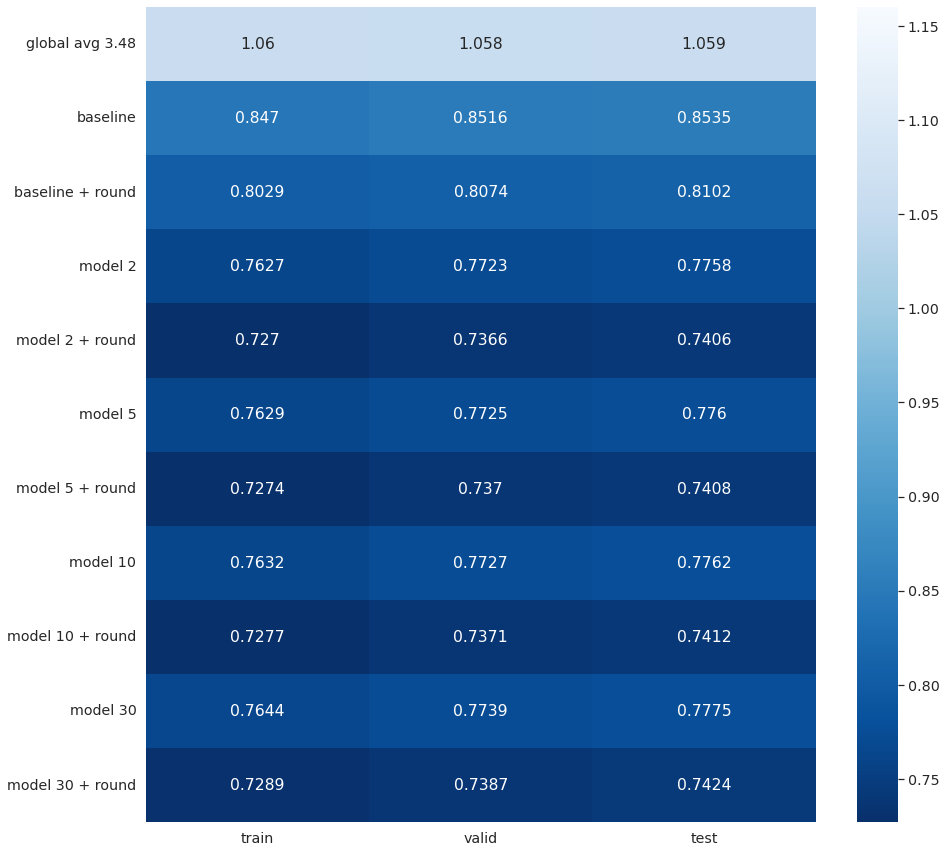

In [20]:
import seaborn as sns

sns.set(rc = {'figure.figsize':(15,15)})
sns.set(font_scale=1.3)
sns.heatmap(
    evaluation,
    annot=True,
    vmin=evaluation.min().min(),
    vmax=evaluation.max().max() + 0.1,
    fmt=".4",
    cmap="Blues_r",
)

In [28]:
df_movies.loc[recommender.recommend_from_movie(
    #"393331-avengers-infinity-war"
    #"234460-skyfall"
    #"110420-mission-impossible-iii"
    "5992-marecku-podejte-mi-pero"
    #"19838-doba-ledova"
    #"301401-rivalove"
)]["genres"]

movie_id
232535-labyrint-lzi                                [Drama, Akční, Thriller]
32435-mrchozrouti                                        [Komedie, Válečný]
10090-dovolena-s-andelem                                          [Komedie]
134363-sam-v-temnote                               [Horor, Thriller, Akční]
282120-lol                                     [Komedie, Drama, Romantický]
24953-letiste                                             [Drama, Thriller]
481213-pribeh-sluzebnice                          [Drama, Sci-Fi, Thriller]
467591-strnadovi                                             [Dokumentární]
452089-nikdys-nebyl                   [Mysteriózní, Krimi, Thriller, Drama]
2411-funny-face                              [Romantický, Komedie, Muzikál]
21953-tisic-dnu-s-annou                                 [Drama, Historický]
317124-hra-na-hrane                                [Krimi, Drama, Thriller]
323531-expendables-postradatelni-3           [Akční, Thriller, Dobrodružný]
110

In [22]:
len(ratings.movie_id.unique())

8670